# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Concatenate, GlobalAveragePooling2D, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import os

2024-08-03 09:18:55.433428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 09:18:55.433534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 09:18:55.557010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [2]:
STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

In [3]:
df = pd.read_csv(STYLES_CSV_PATH, on_bad_lines='skip')
print(f"Total Rows: {df.shape[0]}\nTotal Columns: {df.shape[1]}")

Total Rows: 44424
Total Columns: 10


In [4]:
# Adding Images paths to the df
df['image_path'] = df['id'].apply(lambda x: IMAGES_PATH + str(x) +'.jpg')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...


## Handle NaN Values

In [5]:
df.dropna()
# df = df.apply(lambda col: col.fillna('Unknown').astype(str) if col.name not in ['id'] else col)
df = df.astype({col: str for col in df.columns if col != 'id'})

In [6]:
df.isna().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [7]:
df = df[df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]

## Extracting Brands

In [8]:
def extract_brand(name):
    keywords = ['men', 'man', 'woman', 'women', 'boy', 'girl', 'kid', 'unisex']
    
    name_lower = name.lower()
    
    if "'" in name_lower:
        parts = name_lower.split("'", 1)
        before_quote = parts[0].strip()
        after_quote = parts[1].strip()

        words_before_quote = before_quote.split(' ')
        
        if words_before_quote[-1] in keywords:
            brand = ' '.join(words_before_quote[:-1])
        else:
            brand = before_quote
        
        brand = brand.strip()
    else:
        words = name_lower.split(' ')
        brand = name_lower
        for word in words:
            if word in keywords:
                brand = name_lower.split(word)[0].strip()
                break
        if brand == name_lower:
            brand = name_lower.split(' ')[0]
    
    # Capitalize the first letter of every word in the output
    return brand.title()

In [9]:
def refine_brands(df):
    brands = df['brand'].tolist()
    
    for i, brand in enumerate(brands):
        for j, other_brand in enumerate(brands):
            if i != j:
                if f' {other_brand} ' in f' {brand} ':
                    brands[i] = other_brand
                    break

    df['brand'] = brands

In [10]:
df['brand'] = df['productDisplayName'].apply(extract_brand)
refine_brands(df)

In [11]:
# data = df.copy()

In [12]:
# df = data[:22000]

# Pre-Processing

## Image

In [13]:
IMAGE_DIMS = (100, 100, 3)

In [14]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_DIMS[0], IMAGE_DIMS[1]))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

image_data = np.array([preprocess_image(img_path) for img_path in tqdm(df['image_path'], desc="Preprocessing Images")])

Preprocessing Images: 100%|██████████| 22000/22000 [09:30<00:00, 38.57it/s]


## Encoding Images

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
x = base_model.output
x = GlobalAveragePooling2D()(x)

image_encoder = Model(inputs=base_model.input, outputs=x)

encoded_images = image_encoder.predict(image_data)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 13/688 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step 

I0000 00:00:1722677348.806166     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


688/688 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step


## One Hot

In [16]:
attributes = ["gender", "masterCategory", "subCategory", "articleType", "baseColour", "season", "usage", "brand"]
encoded_attributes = pd.get_dummies(df[attributes]).values

## Tokenizing

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['productDisplayName'])

sequences = tokenizer.texts_to_sequences(df['productDisplayName'])

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Model

## Architecture

In [18]:
def perplexity(y_true, y_pred):
    cross_entropy = tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity

image_input = Input(shape=(2048,), name='image_input')

attributes_input = Input(shape=(encoded_attributes.shape[1],), name='attributes_input')
attr_dense = Dense(256, activation='relu')(attributes_input)
attr_dense = Dense(128, activation='relu')(attr_dense)

combined = Concatenate()([image_input, attr_dense])

combined_repeated = RepeatVector(max_length)(combined)

x = LSTM(256, return_sequences=True)(combined_repeated)
x = LSTM(256, return_sequences=True)(x)
output = TimeDistributed(Dense(len(tokenizer.word_index) + 1, activation='softmax'))(x)

model = Model(inputs=[image_input, attributes_input], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy', perplexity]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training

In [19]:
padded_sequences_expanded = np.expand_dims(padded_sequences, -1)

history = model.fit([encoded_images, encoded_attributes], padded_sequences_expanded, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6188 - loss: 2.9317 - perplexity: 197.1566 - val_accuracy: 0.6477 - val_loss: 2.0244 - val_perplexity: 7.6777
Epoch 2/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6716 - loss: 1.8326 - perplexity: 6.3261 - val_accuracy: 0.6835 - val_loss: 1.7204 - val_perplexity: 5.6544
Epoch 3/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7047 - loss: 1.5389 - perplexity: 4.7103 - val_accuracy: 0.7137 - val_loss: 1.5142 - val_perplexity: 4.5967
Epoch 4/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7282 - loss: 1.3311 - perplexity: 3.8238 - val_accuracy: 0.7308 - val_loss: 1.4031 - val_perplexity: 4.1197
Epoch 5/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7471 - loss: 1.1849 - perplexity: 3.2946 - val_accuracy: 0.7491 - val_loss: 1.3193 - val_perplexity: 3.7898
Epoch 6/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7645 - loss: 1.0845 - perplexity: 2.9794 - val_acc

In [20]:
history = history.history

# Savings

In [21]:
import datetime
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d-%H:%M:%S')
timestamp

'2024-08-03-09:40:26'

In [22]:
DIR_PATH = f'{50}-{timestamp}'
# DIR_PATH = '/kaggle/working'

if not os.path.exists(DIR_PATH):
    os.makedirs(DIR_PATH)

## Saving Model

In [23]:
model.save_weights(os.path.join(DIR_PATH, 'model.weights.h5'))
model.save(os.path.join(DIR_PATH, 'model.keras'))

## Saving History

In [24]:
import pickle

with open(os.path.join(DIR_PATH, 'model.history'), 'wb') as file_pi:
    pickle.dump(history, file_pi)

# Load

In [25]:
# from keras.models import load_model

# model = load_model(os.path.join(DIR_PATH, 'model.keras'), safe_mode=False)

# with open(os.path.join(DIR_PATH, 'model.history'), "rb") as file_pi:
#     history = pickle.load(file_pi)

# Evaluation

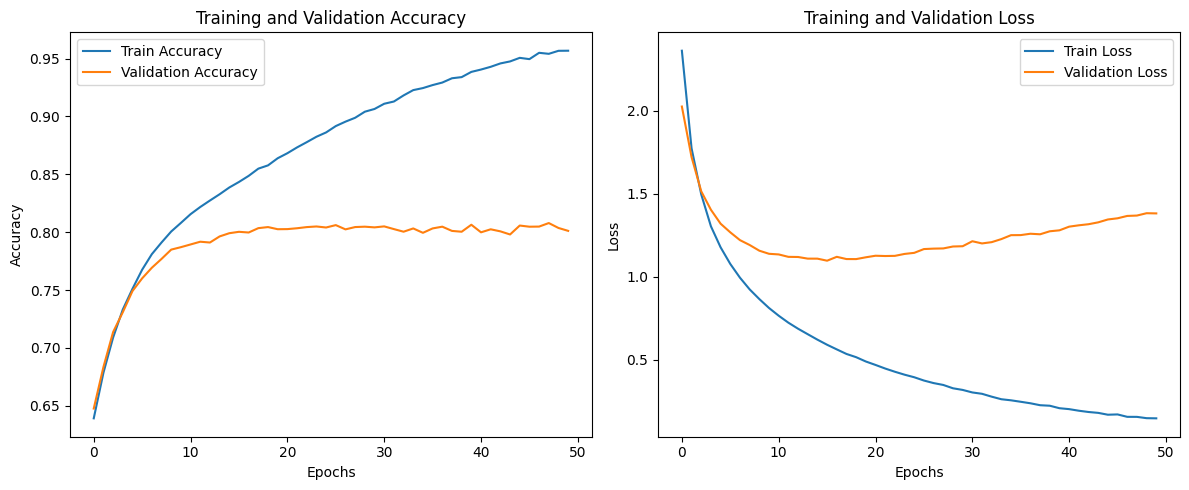

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig(os.path.join(DIR_PATH, 'accuracy_loss.png'))
plt.show()

# Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


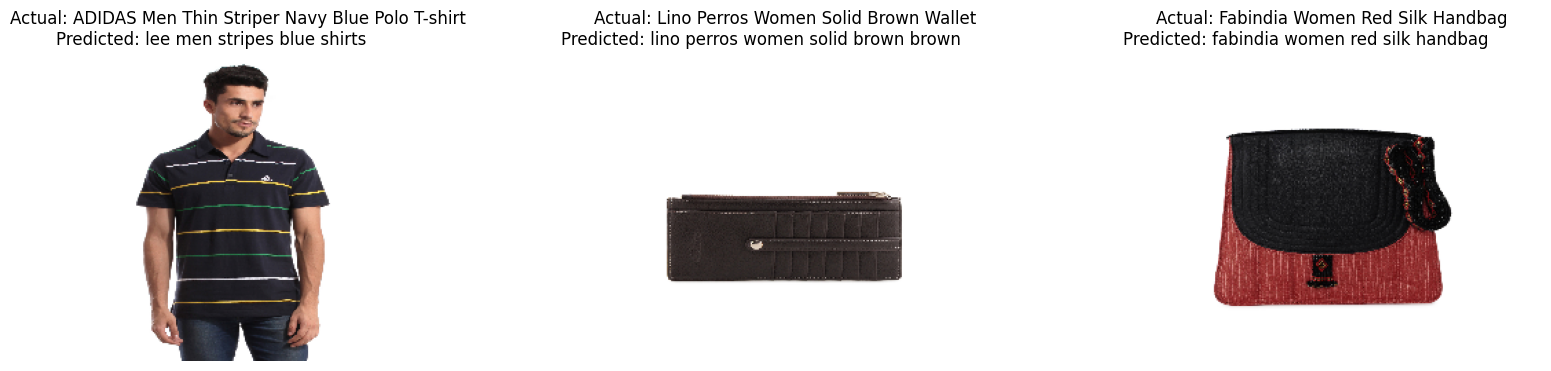

In [66]:
def decode_sequence(sequence):
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    decoded_sequence = ' '.join([reverse_word_index.get(i, '') for i in sequence])
    return decoded_sequence

num_samples = 3
sample_indices = np.random.choice(df.index, num_samples, replace=False)

sample_images = np.array([preprocess_image(df.loc[i, 'image_path']) for i in sample_indices])
sample_encoded_images = image_encoder.predict(sample_images)
sample_encoded_attributes = encoded_attributes[sample_indices]

predicted_sequences = model.predict([sample_encoded_images, sample_encoded_attributes])
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)
    img = image.load_img(df.loc[idx, 'image_path'], target_size=(224, 224))
    plt.imshow(img)
    actual_display_name = df.loc[idx, 'productDisplayName']
    predicted_display_name = decode_sequence(predicted_sequences[i])
    plt.title(f"Actual: {actual_display_name}\nPredicted: {predicted_display_name}")
    plt.axis('off')
    
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d-%H:%M:%S')
plt.savefig(f'sample_predictions-{timestamp}.png')
plt.show()